<a href="https://colab.research.google.com/github/devrayat000/dl_workspace/blob/master/flower_classification_using_transfer_learning_mobilenetv3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tf_keras as keras

2024-11-21 10:22:32.260267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732162952.332468    8916 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732162952.354652    8916 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 10:22:32.506721: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
tf.__version__, np.__version__

('2.18.0', '1.26.4')

Data preprocessing

In [6]:
import pathlib

DATA_URL = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

data_dir = keras.utils.get_file('flower_photos.tar', origin=DATA_URL, cache_dir=".", extract=True)
data_dir = pathlib.Path(data_dir).with_suffix('')

In [175]:
data_dir = data_dir / "flower_photos"

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
print(data_dir)

3670
datasets/flower_photos


Define data loader parameters

In [8]:
BATCH_SIZE = 36
IMG_H = 160
IMG_W = 160
IMG_SIZE = (IMG_W, IMG_H)

In [9]:
train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
    validation_split=0.2,
    subset="training"
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


I0000 00:00:1732162974.014043    8916 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4273 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


In [10]:
val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    seed=123,
    validation_split=0.2,
    subset="validation"
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [11]:
train_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [12]:
class_names = train_ds.class_names
num_classes = len(class_names)

Create testing dataset

In [13]:
val_cardinality = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_cardinality // 5)
val_ds = val_ds.skip(val_cardinality // 5)

Cache the dataset

In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

Data augmentation layers

In [15]:
from tf_keras import layers, Sequential

data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(IMG_H, IMG_W, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="data_augmentation")

In [187]:
data_augmentation.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_3 (RandomFlip)  (None, 160, 160, 3)       0         
                                                                 
 random_rotation_3 (RandomR  (None, 160, 160, 3)       0         
 otation)                                                        
                                                                 
 random_zoom_3 (RandomZoom)  (None, 160, 160, 3)       0         
                                                                 
 random_contrast_3 (RandomC  (None, 160, 160, 3)       0         
 ontrast)                                                        
                                                                 
Total params: 0 (0.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Import pre-trained model inputs

In [16]:
process_input = keras.applications.mobilenet_v3.preprocess_input

Rescale pixel values

In [17]:
rescale = layers.Rescaling(1./127.5, offset=-1)

Create base model from pre-trained convnets

In [18]:
IMG_SHAPE = IMG_SIZE + (3,)

In [195]:
base_model = keras.applications.MobileNetV3Small(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

In [16]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

I0000 00:00:1732007213.797877    8307 cuda_dnn.cc:529] Loaded cuDNN version 90300


(36, 5, 5, 576)


Freeze the cnvolutional base

In [93]:
base_model.trainable = False

In [191]:
# Let's take a look at the base model architecture
# base_model.summary()

Classification head

In [19]:
global_average_layer = layers.GlobalAveragePooling2D()

In [ ]:
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(36, 576)


Prediction layer

In [96]:
prediction_layer = tf.keras.layers.Dense(num_classes)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(36, 5)


Dropout layer

In [20]:
dropout_layer = layers.Dropout(0.2)

In [197]:
inputs = keras.Input(shape=IMG_SHAPE)
x = data_augmentation(inputs)
x = process_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = dropout_layer(x)
outputs = keras.layers.Dense(num_classes)(x)

model_1 = keras.Model(inputs, outputs)

In [198]:
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, 160, 160, 3)       0         
 ial)                                                            
                                                                 
 MobilenetV3small (Function  (None, 5, 5, 576)         939120    
 al)                                                             
                                                                 
 global_average_pooling2d_1  (None, 576)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 576)               0         
                                                             

In [199]:
len(model_1.trainable_variables)

140

In [202]:
tf.keras.utils.plot_model(model_1, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


Compile the model

In [203]:
base_learning_rate = 0.0001

In [204]:
model_1.compile(
    optimizer=keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [205]:
initial_epochs = 10

In [206]:
history_1 = model_1.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
)

Epoch 1/10


I0000 00:00:1732161530.910860   62574 service.cc:148] XLA service 0x7628d4bab480 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732161530.911012   62574 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-21 09:58:50.936935: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-21 09:58:50.989883: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1732161531.039587   62574 device_compiler.h:188] Compiled cluster using XLA! 

82/82 [==============================] - 31s 80ms/step - loss: 1.1632 - accuracy: 0.5470 - val_loss: 0.6633 - val_accuracy: 0.7729
Epoch 2/10
82/82 [==============================] - 3s 38ms/step - loss: 0.6263 - accuracy: 0.7626 - val_loss: 0.4905 - val_accuracy: 0.8322
Epoch 3/10
82/82 [==============================] - 3s 37ms/step - loss: 0.4929 - accuracy: 0.8174 - val_loss: 0.4759 - val_accuracy: 0.8254
Epoch 4/10
82/82 [==============================] - 3s 38ms/step - loss: 0.4013 - accuracy: 0.8508 - val_loss: 0.3740 - val_accuracy: 0.8661
Epoch 5/10
82/82 [==============================] - 3s 40ms/step - loss: 0.3373 - accuracy: 0.8787 - val_loss: 0.3733 - val_accuracy: 0.8593
Epoch 6/10
82/82 [==============================] - 3s 36ms/step - loss: 0.3148 - accuracy: 0.8801 - val_loss: 0.3882 - val_accuracy: 0.8559
Epoch 7/10
82/82 [==============================] - 3s 35ms/step - loss: 0.2883 - accuracy: 0.8931 - val_loss: 0.3588 - val_accuracy: 0.8610
Epoch 8/10
82/82 [=====

Define `plot_history` function

In [105]:
def plot_history(history, epochs):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']

  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

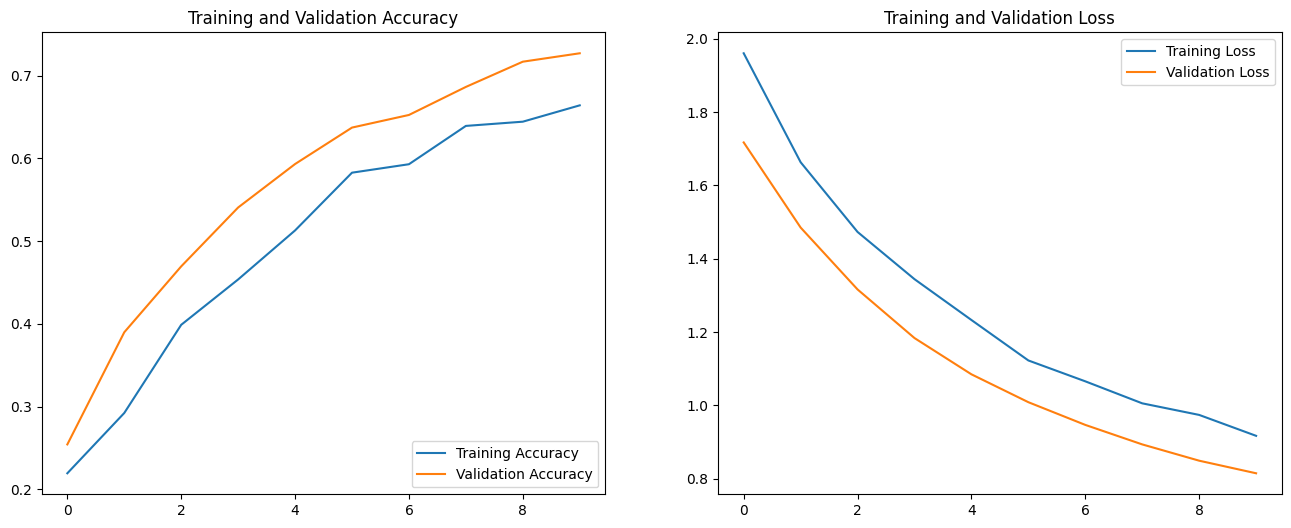

In [106]:
plot_history(history_1, epochs=initial_epochs)

### Fine Tuning

Unfreeze top layers of the model

In [107]:
base_model.trainable = True

Freeze only the bottom layers

In [108]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  157


Compile the model again

In [109]:
model_1.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=['accuracy'],
)

In [110]:
model_1.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Small (Functional)        │ (None, 5, 5, 576)           │         939,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 576)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 576)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 5)                   │           2,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 942,005 (3.59 MB)

 Trainable params: 758,085 (2.89 MB)

 Non-trainable params: 183,920 (718.44 KB)

In [111]:
len(model_1.trainable_variables)

51

Continue training the model

In [112]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_1_fine = model_1.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history_1.epoch),
    validation_data=val_ds,
)

Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.5912 - loss: 1.0571 - val_accuracy: 0.7492 - val_loss: 0.7680
Epoch 12/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.6175 - loss: 1.0306 - val_accuracy: 0.7627 - val_loss: 0.7263
Epoch 13/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6825 - loss: 0.8966 - val_accuracy: 0.7678 - val_loss: 0.6885
Epoch 14/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6549 - loss: 0.9055 - val_accuracy: 0.7831 - val_loss: 0.6558
Epoch 15/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.6930 - loss: 0.8096 - val_accuracy: 0.7898 - val_loss: 0.6263
Epoch 16/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7106 - loss: 0.7932 - val_accuracy: 0.8051 - val_loss: 0.5999
Epoch 17/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7096 - loss: 0.7724 - val_accuracy: 0.8136 - val_loss: 0.5755
Epoch 18/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7418 - loss: 0.7059 - val_accuracy: 0

In [113]:
def plot_fine_history(history, history_fine, initial_epochs, final_epochs):
  epochs = initial_epochs + final_epochs
  acc = history.history['accuracy'] + history_fine.history['accuracy']
  val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

  loss = history.history['loss'] + history_fine.history['loss']
  val_loss = history.history['val_loss'] + history_fine.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(16, 8))
  plt.subplot(2, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(2, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

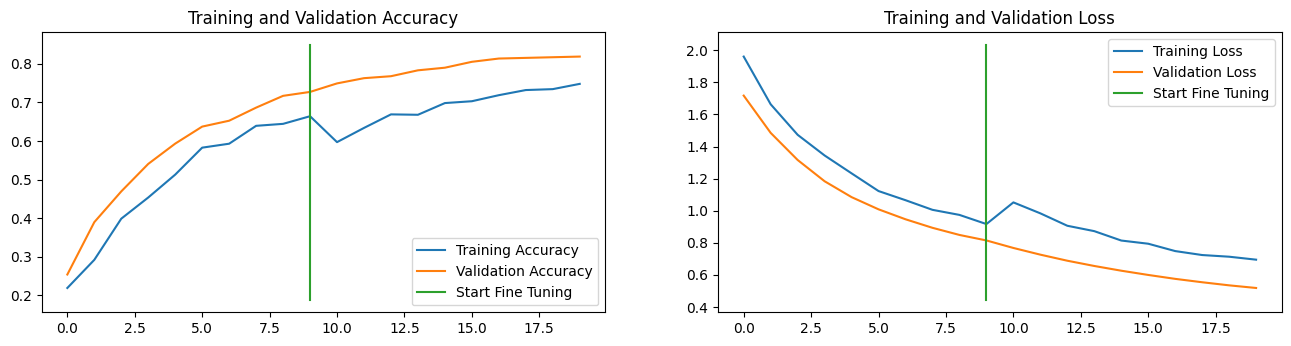

In [114]:
plot_fine_history(
    history=history_1,
    history_fine=history_1_fine,
    initial_epochs=initial_epochs,
    final_epochs=fine_tune_epochs,
)

Evaluate the prediction

In [115]:
loss, accuracy = model_1.evaluate(test_ds)
print('Test accuracy :', accuracy)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7852 - loss: 0.4855 
Test accuracy : 0.7708333134651184


Predictions:
 (36, 5)
Labels:
 (36,)


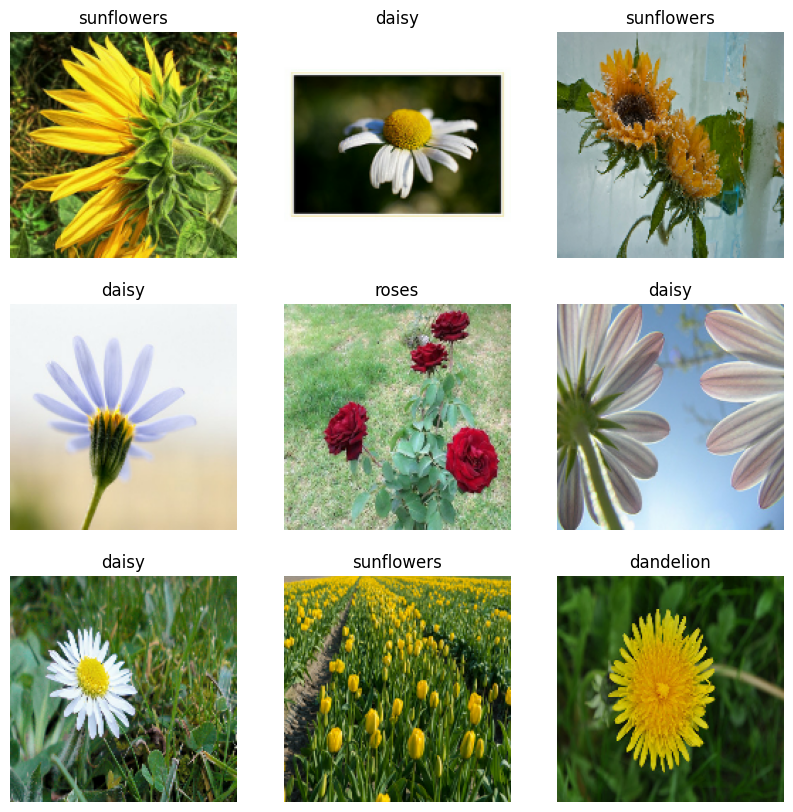

In [121]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model_1.predict_on_batch(image_batch)

print('Predictions:\n', predictions.shape)
print('Labels:\n', label_batch.shape)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[np.argmax(predictions[i])])
  plt.axis("off")

## Train the other models

MobileNetV3Large

In [122]:
base_model_2 = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet'
)

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [123]:
base_model_2.trainable = False

In [124]:
base_model_2.summary()

Model: "MobileNetV3Large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8             │ (None, 160, 160, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_6 (Rescaling)   │ (None, 160, 160, 3)    │              0 │ input_layer_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv (Conv2D)             │ (None, 80, 80, 16)     │            432 │ rescaling_6[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv_bn                   │ (None, 80, 80, 16)     │             64 │ conv[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_54             │ (None, 80, 80, 16)     │              0 │ conv_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 80, 80, 16)     │            144 │ activation_54[0][0]    │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 80, 80, 16)     │             64 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_42 (ReLU)           │ (None, 80, 80, 16)     │              0 │ expanded_conv_depthwi… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 80, 80, 16)     │            256 │ re_lu_42[0][0]         │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_bn  │ (None, 80, 80, 16)     │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_add (Add)   │ (None, 80, 80, 16)     │              0 │ activation_54[0][0],   │
│                           │                        │                │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand    │ (None, 80, 80, 64)     │          1,024 │ expanded_conv_add[0][… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_expand_bn │ (None, 80, 80, 64)     │            256 │ expanded_conv_1_expan… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_43 (ReLU)           │ (None, 80, 80, 64)     │              0 │ expanded_conv_1_expan… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_1_depth

 Total params: 2,996,352 (11.43 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,996,352 (11.43 MB)

In [130]:
prediction_layer_2 = tf.keras.layers.Dense(num_classes)

In [131]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
y = data_augmentation(inputs)
y = process_input(y)
y = base_model_2(y, training=False)
y = global_average_layer(y)
y = dropout_layer(y)
outputs = prediction_layer_2(y)

model_2 = tf.keras.Model(inputs, outputs)

In [132]:
model_2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 5, 5, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           4,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 4,805 (18.77 KB)

 Non-trainable params: 2,996,352 (11.43 MB)

In [133]:
len(model_2.trainable_variables)

2

In [134]:
model_2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [135]:
history_2 = model_2.fit(
    train_ds,
    epochs=initial_epochs,
    validation_data=val_ds,
)

Epoch 1/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 17s 84ms/step - accuracy: 0.2607 - loss: 2.0511 - val_accuracy: 0.3576 - val_loss: 1.5569
Epoch 2/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3536 - loss: 1.5853 - val_accuracy: 0.4966 - val_loss: 1.2391
Epoch 3/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.4995 - loss: 1.3068 - val_accuracy: 0.6203 - val_loss: 1.0342
Epoch 4/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5421 - loss: 1.1968 - val_accuracy: 0.7034 - val_loss: 0.9016
Epoch 5/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6017 - loss: 1.0644 - val_accuracy: 0.7373 - val_loss: 0.8095
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6461 - loss: 0.9423 - val_accuracy: 0.7644 - val_loss: 0.7393
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6711 - loss: 0.8680 - val_accuracy: 0.7814 - val_loss: 0.6852
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6917 - loss: 0.8199 - val_accuracy: 0.7881 - 

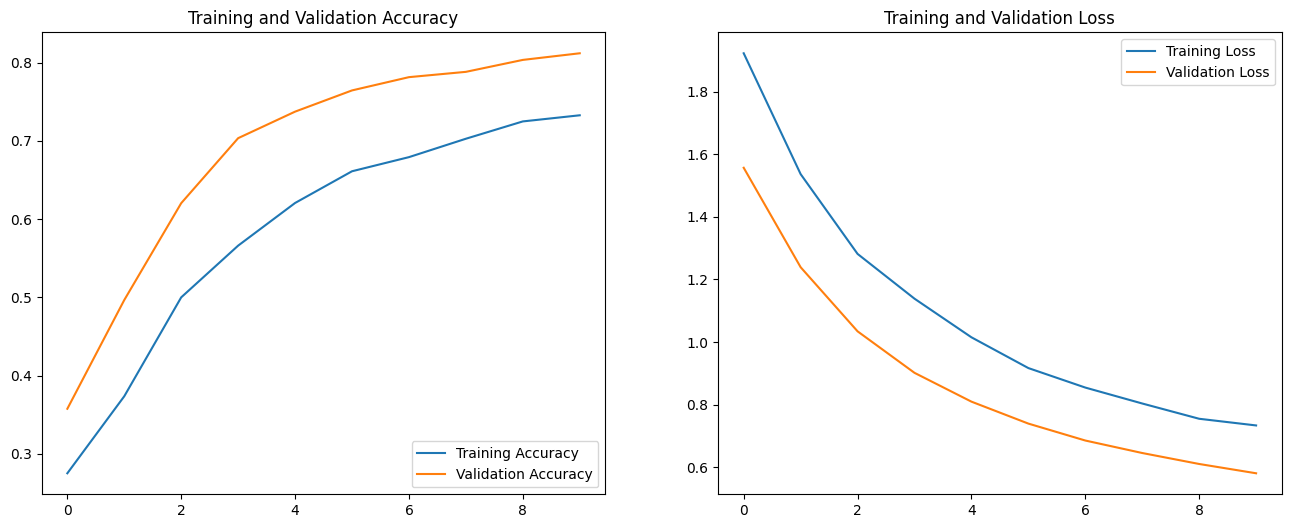

In [136]:
plot_history(history_2, epochs=initial_epochs)

In [137]:
base_model_2.trainable = True

In [140]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model_2.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model_2.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  187


In [141]:
model_2.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
    metrics=['accuracy'],
)

In [142]:
model_2.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)          │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_2 (Sequential)            │ (None, 160, 160, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ MobileNetV3Large (Functional)        │ (None, 5, 5, 960)           │       2,996,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 960)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 960)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │           4,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 2,816,805 (10.75 MB)

 Non-trainable params: 184,352 (720.12 KB)

In [143]:
len(model_2.trainable_variables)

79

In [144]:
history_2_fine = model_2.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history_2.epoch),
    validation_data=val_ds,
)

Epoch 11/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 94ms/step - accuracy: 0.6408 - loss: 0.9216 - val_accuracy: 0.8169 - val_loss: 0.5461
Epoch 12/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 80ms/step - accuracy: 0.6870 - loss: 0.8323 - val_accuracy: 0.8169 - val_loss: 0.5197
Epoch 13/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.7031 - loss: 0.8073 - val_accuracy: 0.8220 - val_loss: 0.4968
Epoch 14/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 76ms/step - accuracy: 0.7403 - loss: 0.7072 - val_accuracy: 0.8237 - val_loss: 0.4733
Epoch 15/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.7583 - loss: 0.6350 - val_accuracy: 0.8305 - val_loss: 0.4523
Epoch 16/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - accuracy: 0.7896 - loss: 0.5713 - val_accuracy: 0.8373 - val_loss: 0.4316
Epoch 17/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.7934 - loss: 0.5640 - val_accuracy: 0.8525 - val_loss: 0.4140
Epoch 18/20
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - accuracy: 0.8103 - loss: 0.5085 - val_accuracy: 

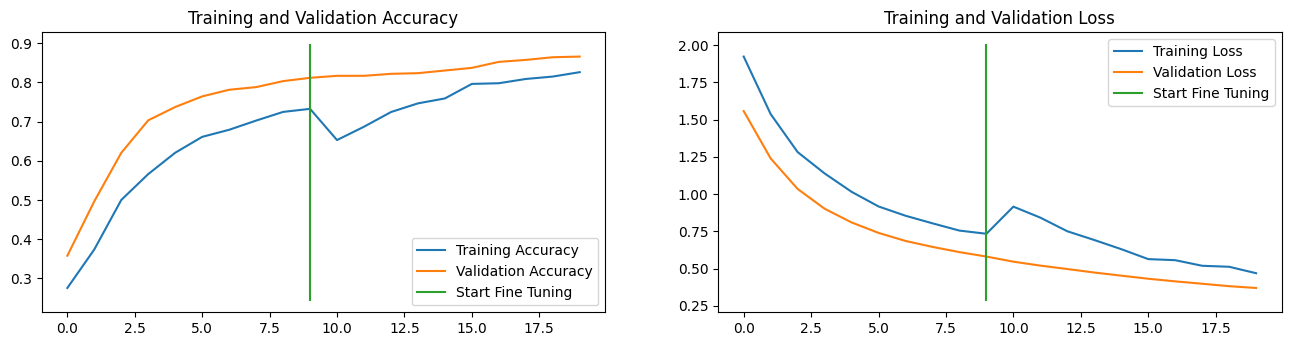

In [145]:
plot_fine_history(
    history=history_2,
    history_fine=history_2_fine,
    initial_epochs=initial_epochs,
    final_epochs=fine_tune_epochs,
)

Define a function for training models more efficiently

In [21]:
from sklearn.metrics import classification_report
import seaborn as sns

In [ ]:
def train_model(base_model: tf.keras.Model, initial_epochs=10, fine_epochs=10, learning_rate=0.0001):
  # First, freeze the pre-trained model
  base_model.trainable = False

  # Define the custom model using functional api
  inputs = tf.keras.Input(shape=IMG_SHAPE)
  y = data_augmentation(inputs)
  y = process_input(y)
  y = base_model(y, training=False)
  y = global_average_layer(y)
  y = dropout_layer(y)
  outputs = tf.keras.layers.Dense(num_classes)(y)

  model = tf.keras.Model(inputs, outputs)

  # Compile the model for the first step
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
      metrics=['accuracy'],
  )

  # Fit the model without modifying the weights
  history = model.fit(
      train_ds,
      epochs=initial_epochs,
      validation_data=val_ds,
  )

  # Unfreeze the base model
  base_model.trainable = True

  # Fine-tune from this layer onwards
  fine_tune_at = 100

  # Freeze all the layers before the `fine_tune_at` layer
  for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

  # Compile the model again with unfreezed top layers
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate/10),
      metrics=['accuracy'],
  )

  # Fine-tune the model
  history_fine = model.fit(
      train_ds,
      epochs=initial_epochs+fine_epochs,
      initial_epoch=len(history.epoch),
      validation_data=val_ds,
  )

  # Plot the results
  epochs = initial_epochs + fine_epochs

  acc = history.history['accuracy'] + history_fine.history['accuracy']
  val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']

  loss = history.history['loss'] + history_fine.history['loss']
  val_loss = history.history['val_loss'] + history_fine.history['val_loss']

  epochs_range = range(epochs)

  plt.figure(figsize=(18, 8))

  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='lower right')
  plt.title('Training and Validation Accuracy')

  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
  plt.legend(loc='upper right')
  plt.title('Training and Validation Loss')
  plt.show()

  # Retrieve a batch of images from the test set
  image_batch, label_batch = test_ds.as_numpy_iterator().next()
  predictions = model.predict_on_batch(image_batch)

  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[np.argmax(predictions[i])])
    plt.axis("off")

  loss, accuracy = model.evaluate(test_ds)
  print('Test accuracy :', accuracy)
  
  # Generate predictions
  y_pred = model.predict(test_ds)  # Model predictions
  y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class labels
  y_true = np.array([labels for _, labels in test_ds]).flatten()  # True labels

  # Generate Classification Report
  report = classification_report(y_true, y_pred_classes, target_names=class_names)
  print("Classification Report:")
  print(report)

  # Generate Confusion Matrix
  cm = tf.math.confusion_matrix(y_true, y_pred_classes)
  print("Confusion Matrix:")
  print(cm)

  # Optionally, visualize the confusion matrix
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
              yticklabels=class_names)
  plt.ylabel('True Label')
  plt.xlabel('Predicted Label')
  plt.title('Confusion Matrix')
  plt.show()

  return model

Train the MobileNetV3Large again with 10, 10 epochs

/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.12/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - accuracy: 0.2375 - loss: 2.1695 - val_accuracy: 0.3864 - val_loss: 1.6154
Epoch 2/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.3379 - loss: 1.6706 - val_accuracy: 0.5068 - val_loss: 1.3208
Epoch 3/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.4554 - loss: 1.4064 - val_accuracy: 0.5966 - val_loss: 1.1294
Epoch 4/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5382 - loss: 1.2159 - val_accuracy: 0.6475 - val_loss: 0.9973
Epoch 5/5
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5875 - loss: 1.0892 - val_accuracy: 0.6881 - val_loss: 0.8976
Epoch 6/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 19s 84ms/step - accuracy: 0.5088 - loss: 1.3093 - val_accuracy: 0.6881 - val_loss: 0.8477
Epoch 7/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.5545 - loss: 1.1997 - val_accuracy: 0.6898 - val_loss: 0.8091
Epoch 8/10
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 

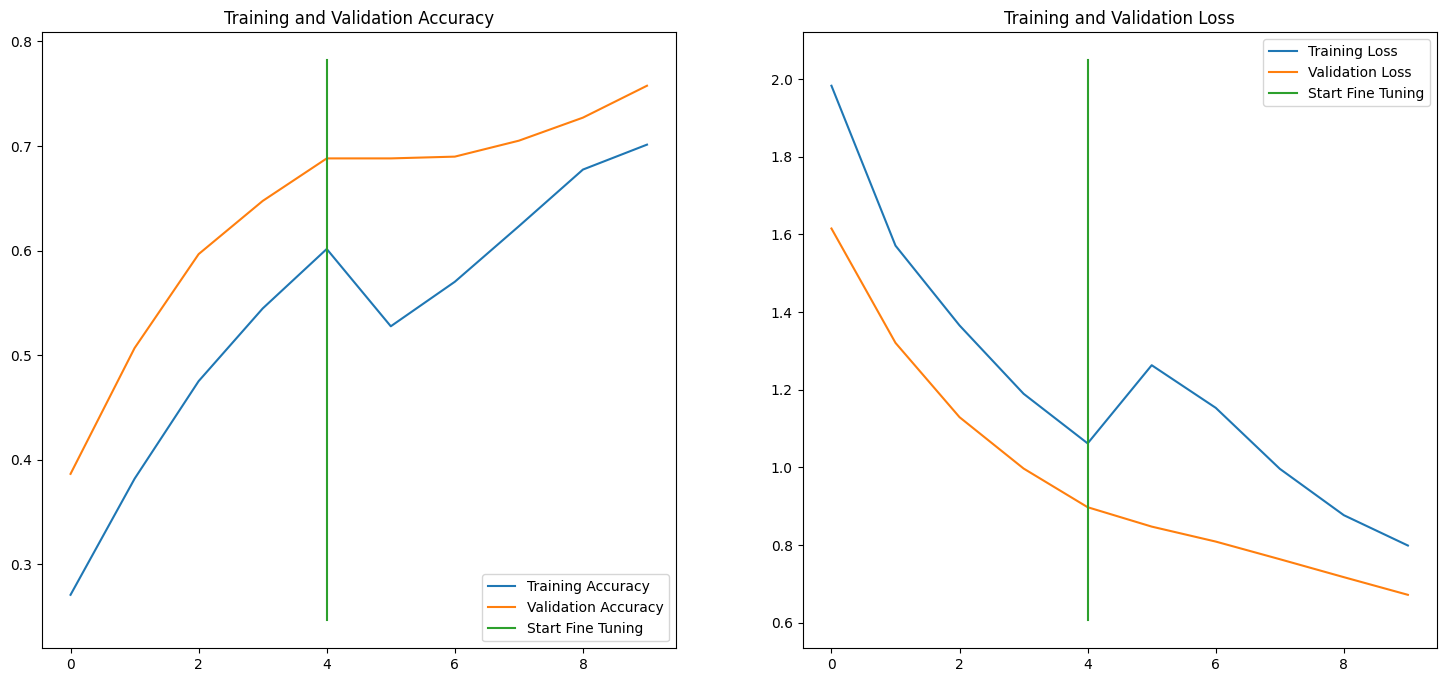

2024-11-19 15:14:00.673518: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7630 - loss: 0.6607
Test accuracy : 0.7569444179534912
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


2024-11-19 15:14:03.223625: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


ValueError: Number of classes, 5, does not match size of target_names, 2. Try specifying the labels parameter

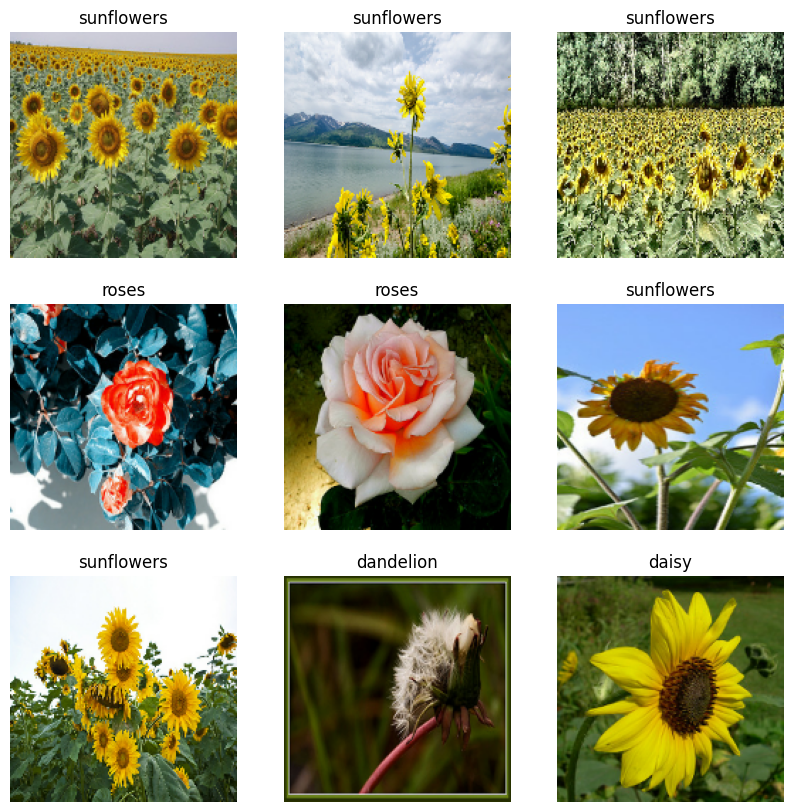

In [22]:
# Re-import the MobileNetV3Large again for fine-tuning
base_model_3 = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

model_3 = train_model(base_model=base_model_3, initial_epochs=5, fine_epochs=5)

Train the MobileNetV3Large again with 15, 15 epochs

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 56ms/step - accuracy: 0.2263 - loss: 2.1728 - val_accuracy: 0.3186 - val_loss: 1.6415
Epoch 2/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.3500 - loss: 1.6420 - val_accuracy: 0.4814 - val_loss: 1.3141
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.4743 - loss: 1.3325 - val_accuracy: 0.5695 - val_loss: 1.1002
Epoch 4/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5007 - loss: 1.2265 - val_accuracy: 0.6373 - val_loss: 0.9547
Epoch 5/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.5846 - loss: 1.0676 - val_accuracy: 0.7000 - val_loss: 0.8502
Epoch 6/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6168 - loss: 1.0093 - val_accuracy: 0.7458 - val_loss: 0.7757
Epoch 7/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.6667 - loss: 0.8747 - val_accuracy: 0.7610 - val_loss: 0.7188
Epoch 8/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - accuracy: 0.7070 - loss: 0.8369 - val_accuracy: 0.7797 - 

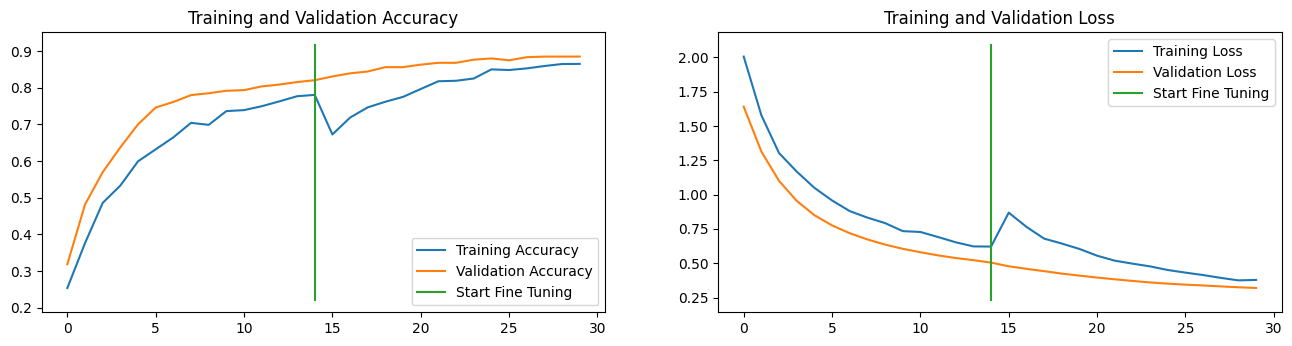

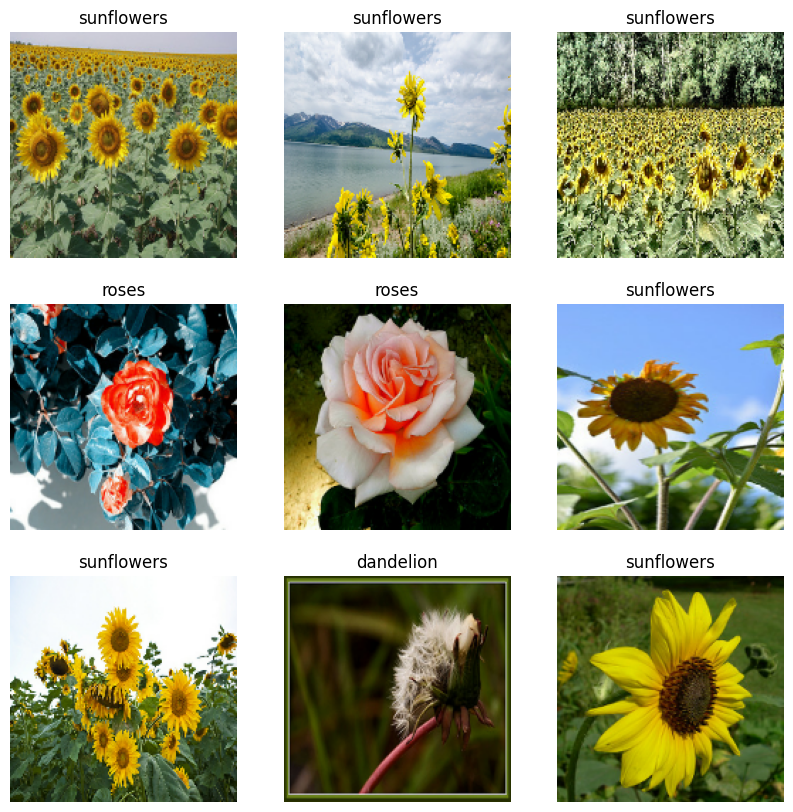

In [151]:
# Re-import the MobileNetV3Large again for fine-tuning
base_model_4 = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

model_4 = train_model(base_model=base_model_4, initial_epochs=15, fine_epochs=15)

Train the MobileNetV3Large again with 30, 30 epochs

/usr/local/lib/python3.10/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 11s 51ms/step - accuracy: 0.1708 - loss: 2.1556 - val_accuracy: 0.2915 - val_loss: 1.6470
Epoch 2/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.2913 - loss: 1.7064 - val_accuracy: 0.4695 - val_loss: 1.3221
Epoch 3/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.4216 - loss: 1.4186 - val_accuracy: 0.5847 - val_loss: 1.1154
Epoch 4/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.5412 - loss: 1.1908 - val_accuracy: 0.6508 - val_loss: 0.9664
Epoch 5/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - accuracy: 0.6022 - loss: 1.0695 - val_accuracy: 0.6831 - val_loss: 0.8646
Epoch 6/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6256 - loss: 0.9775 - val_accuracy: 0.7034 - val_loss: 0.7859
Epoch 7/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - accuracy: 0.6805 - loss: 0.8809 - val_accuracy: 0.7407 - val_loss: 0.7266
Epoch 8/30
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.7266 - loss: 0.8014 - val_accuracy: 0.7559 - 

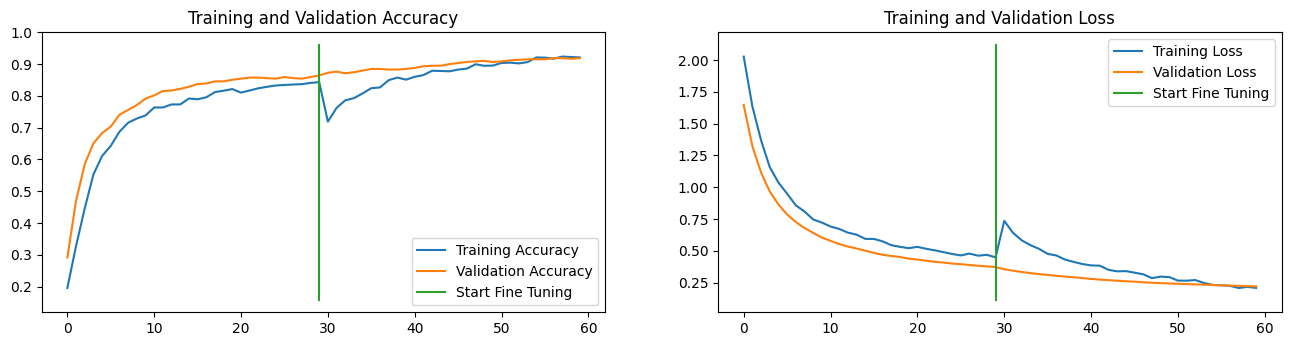

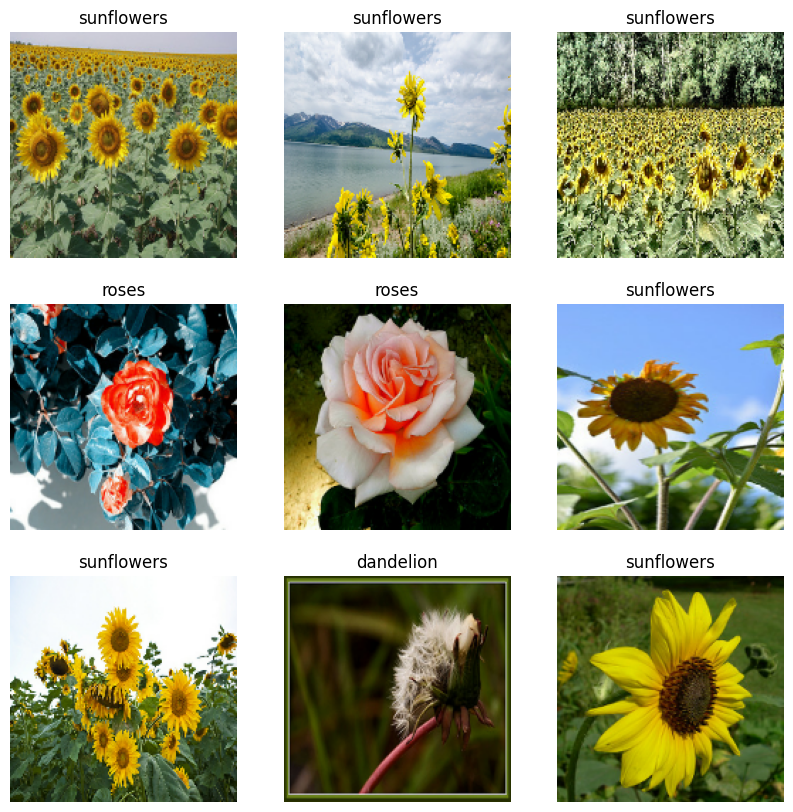

In [152]:
# Re-import the MobileNetV3Large again for fine-tuning
base_model_5 = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

model_5 = train_model(base_model=base_model_5, initial_epochs=30, fine_epochs=30)

Train the MobileNetV3Large again with 50, 50 epochs

/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.12/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.1710 - loss: 2.3660 - val_accuracy: 0.2492 - val_loss: 1.8173
Epoch 2/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.2701 - loss: 1.8375 - val_accuracy: 0.3932 - val_loss: 1.4250
Epoch 3/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3712 - loss: 1.5269 - val_accuracy: 0.5305 - val_loss: 1.1614
Epoch 4/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.4990 - loss: 1.2670 - val_accuracy: 0.6339 - val_loss: 0.9841
Epoch 5/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.5618 - loss: 1.1541 - val_accuracy: 0.7000 - val_loss: 0.8664
Epoch 6/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6222 - loss: 1.0193 - val_accuracy: 0.7424 - val_loss: 0.7824
Epoch 7/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6638 - loss: 0.9194 - val_accuracy: 0.7644 - val_loss: 0.7170
Epoch 8/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.6957 - loss: 0.8244 - val_accuracy: 0.7864 - 

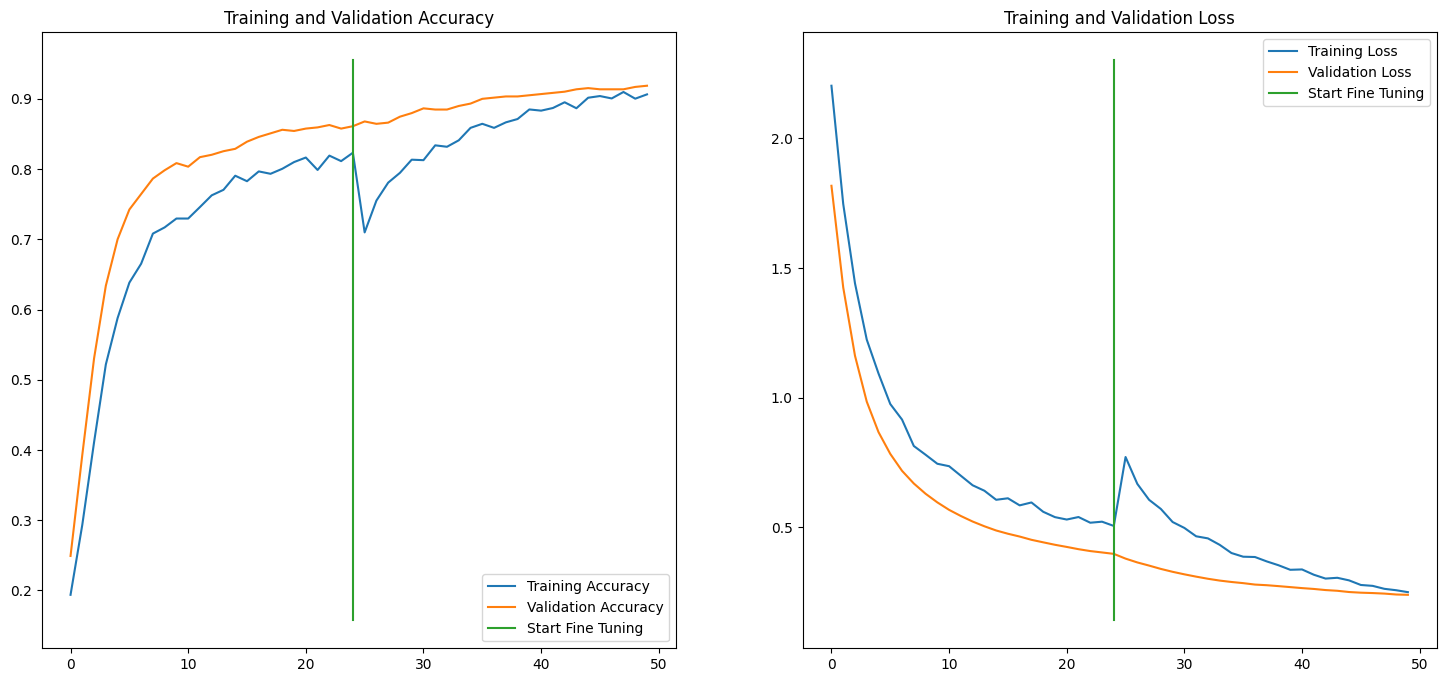

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9019 - loss: 0.2585
Test accuracy : 0.9027777910232544
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
Classification Report:
              precision    recall  f1-score   support

       daisy       0.95      0.95      0.95        21
   dandelion       0.96      0.93      0.95        29
       roses       0.90      0.81      0.85        32
  sunflowers       1.00      0.94      0.97        31
      tulips       0.76      0.90      0.82        31

    accuracy                           0.90       144
   macro avg       0.91      0.91      0.91       144
weighted avg       0.91      0.90      0.90       144



2024-11-19 15:49:46.148882: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Confusion Matrix:
tf.Tensor(
[[20  1  0  0  0]
 [ 1 27  0  0  1]
 [ 0  0 26  0  6]
 [ 0  0  0 29  2]
 [ 0  0  3  0 28]], shape=(5, 5), dtype=int32)


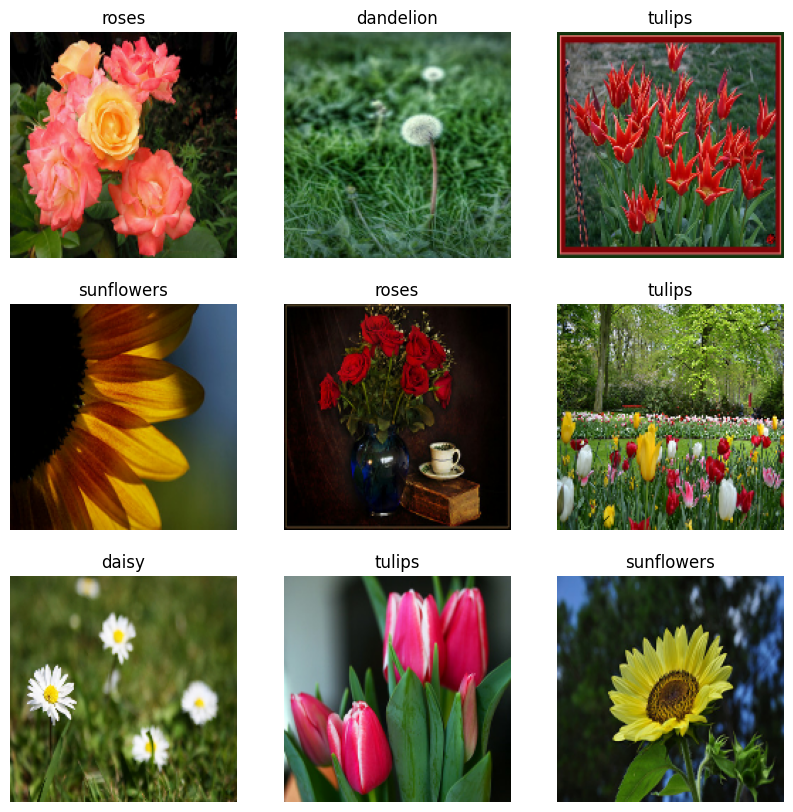

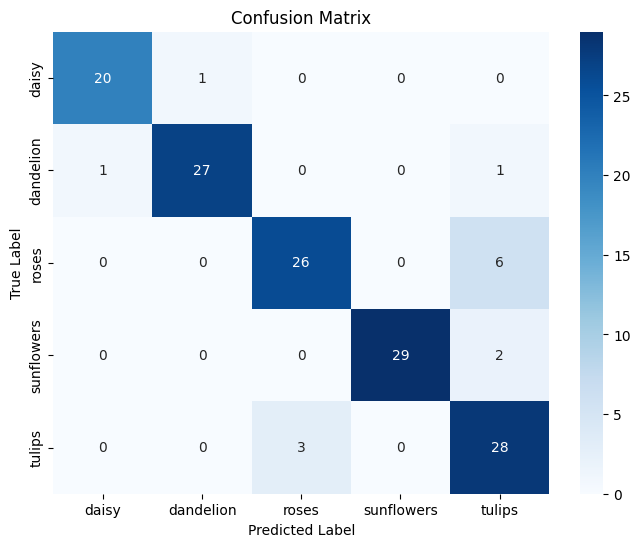

In [31]:
# Re-import the MobileNetV3Large again for fine-tuning
base_model_6 = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

model_6 = train_model(base_model=base_model_6, initial_epochs=25, fine_epochs=25)

In [32]:
model_6.save("./models/flower_net.keras")

/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


Epoch 1/50


I0000 00:00:1732121213.639997   62586 cuda_dnn.cc:529] Loaded cuDNN version 90300


82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 53ms/step - accuracy: 0.2243 - loss: 2.1653 - val_accuracy: 0.3831 - val_loss: 1.4989
Epoch 2/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.3479 - loss: 1.6383 - val_accuracy: 0.5136 - val_loss: 1.2149
Epoch 3/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4461 - loss: 1.3923 - val_accuracy: 0.6153 - val_loss: 1.0320
Epoch 4/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5367 - loss: 1.2066 - val_accuracy: 0.6780 - val_loss: 0.8993
Epoch 5/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.5676 - loss: 1.0974 - val_accuracy: 0.7068 - val_loss: 0.8068
Epoch 6/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6254 - loss: 0.9875 - val_accuracy: 0.7373 - val_loss: 0.7430
Epoch 7/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6636 - loss: 0.9089 - val_accuracy: 0.7644 - val_loss: 0.6852
Epoch 8/50
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - accuracy: 0.6979 - loss: 0.8187 - val_accuracy: 0.7678 - val_loss: 0

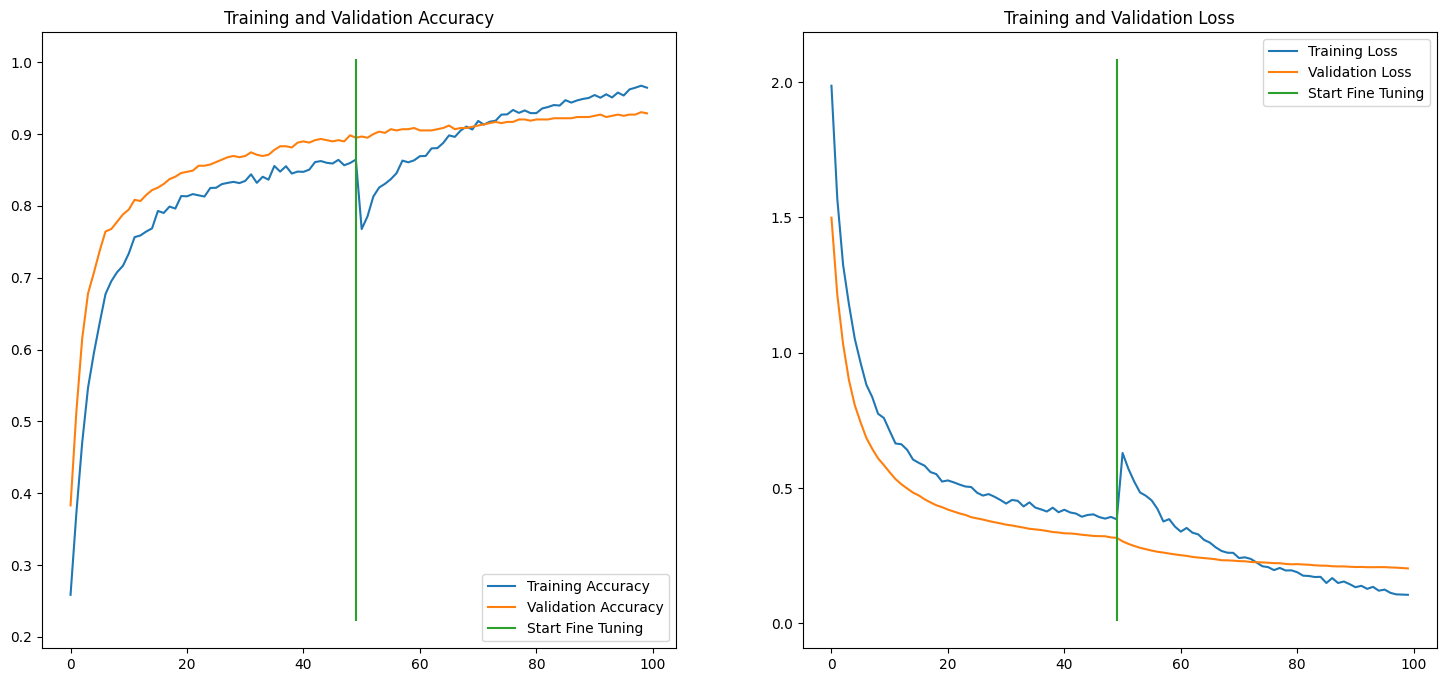

2024-11-20 22:52:39.631306: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9222 - loss: 0.1902
Test accuracy : 0.9166666865348816
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
Classification Report:
              precision    recall  f1-score   support

       daisy       0.91      0.95      0.93        21
   dandelion       0.96      0.86      0.91        29
       roses       0.91      0.94      0.92        32
  sunflowers       1.00      0.94      0.97        31
      tulips       0.82      0.90      0.86        31

    accuracy                           0.92       144
   macro avg       0.92      0.92      0.92       144
weighted avg       0.92      0.92      0.92       144



2024-11-20 22:52:42.063635: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Confusion Matrix:
tf.Tensor(
[[20  1  0  0  0]
 [ 2 25  0  0  2]
 [ 0  0 30  0  2]
 [ 0  0  0 29  2]
 [ 0  0  3  0 28]], shape=(5, 5), dtype=int32)


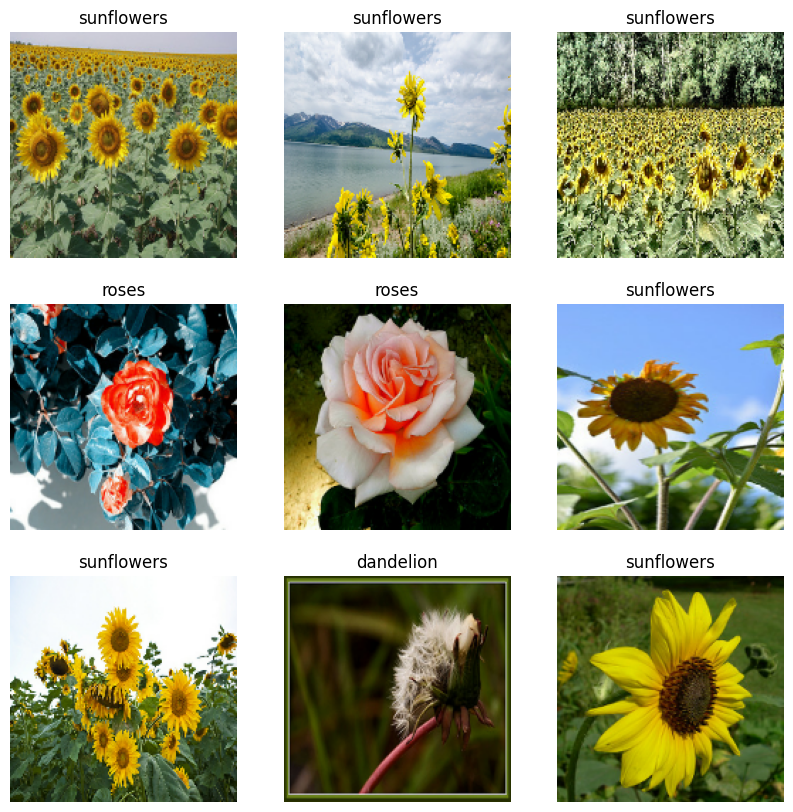

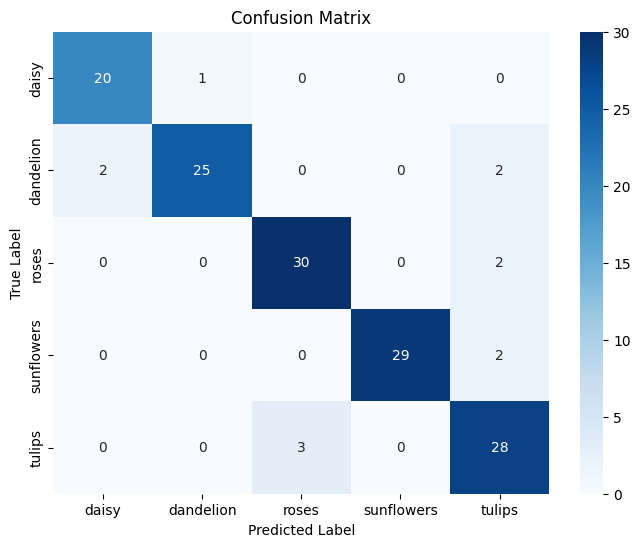

In [23]:
# Re-import the MobileNetV3Large again for fine-tuning
base_model_7 = tf.keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

model_7 = train_model(base_model=base_model_7, initial_epochs=50, fine_epochs=50)

In [22]:
import tensorflowjs as tfjs
tfjs.__version__

'4.22.0'

In [23]:
tfjs.converters.save_keras_model(model_7, "./models/flower_net_js")

failed to lookup keras version from the file,
    this is likely a weight only file


In [24]:
model_7.save("./models/flower_net_2.keras")

In [25]:
model_x = tf.keras.models.load_model('models/flower_net_2.keras')

In [30]:
tfjs.converters.save_keras_model(model_x, "./models/baljs")

failed to lookup keras version from the file,
    this is likely a weight only file


In [62]:
test_img, _ = next(iter(test_ds))
# test_img.shape
test_img = test_img[0]
dd = tf.constant(np.array([test_img]), dtype=tf.float32)
prediction = model_x.predict(dd)
prediction = class_names[np.argmax(prediction)]
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


'roses'

In [54]:
resizing = tf.keras.layers.Resizing(100, 100)
resized = resizing(dd)
prediction = model_x.predict(resized)
prediction = class_names[np.argmax(prediction)]
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


'roses'

In [79]:
class FlowerNetModel(tf.keras.Model):
    def __init__(self, class_names=class_names):
        super().__init__()
        self.class_names = class_names
        self.resizing = tf.keras.layers.Resizing(IMG_SIZE[0], IMG_SIZE[1])

    def call(self, inputs):
        resized = resizing(inputs)
        prediction = model_7.predict(resized)
        prediction = [self.class_names[np.argmax(p)] for p in prediction]
        print(prediction)
        return prediction

In [80]:
model_f = FlowerNetModel(class_names=class_names)

In [82]:
model_7.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 160, 160, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 5, 5, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         4,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,817,964 (22.19 MB)

 Trainable params: 2,816,805 (10.75 MB)

 Non-trainable params: 184,352 (720.12 KB)

 Optimizer params: 2,816,807 (10.75 MB)

In [88]:
inputs = tf.keras.Input(batch_shape=IMG_SHAPE, name='input_image')
x = tf.keras.layers.Flatten()(inputs)
outputs = tf.keras.layers.Dense(num_classes)(x)

model_mm = tf.keras.Model(inputs, outputs)

model_mm.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (160, 160, 3)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (160, 480)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (160, 5)               │         2,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,405 (9.39 KB)

 Trainable params: 2,405 (9.39 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
tfjs.converters.save_keras_model(model_mm, "./models/mm_js_2")

failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
data_augmentation_2 = tf.keras.Sequential([
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

In [23]:
def retrain_model(base_model: keras.Model, initial_epochs=10, fine_epochs=10, learning_rate=0.0001, name=None):
    # First, freeze the pre-trained model
    keras.backend.set_learning_phase(1)
    base_model.trainable = False

    # Define the custom model using functional api
    inputs = keras.Input(shape=IMG_SHAPE, name='input_image')
    # y = data_augmentation(inputs)
    y = keras.layers.Lambda(lambda img: data_augmentation(
        img) if keras.backend.learning_phase() else img)(inputs)
    y = process_input(y)
    y = base_model(y, training=False)
    y = global_average_layer(y)
    y = dropout_layer(y)
    outputs = keras.layers.Dense(num_classes, name="output")(y)

    model = keras.Model(inputs, outputs, name=name)

    # Compile the model for the first step
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy'],
    )

    early_stopping = keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=3,
        restore_best_weights=True,
    )

    # Fit the model without modifying the weights
    history = model.fit(
        train_ds,
        epochs=initial_epochs,
        validation_data=val_ds,
        callbacks=[early_stopping],
    )

    # Unfreeze the base model
    base_model.trainable = True

    # Fine-tune from this layer onwards
    fine_tune_at = 100

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False

    # Compile the model again with unfreezed top layers
    model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=keras.optimizers.RMSprop(learning_rate=learning_rate/10),
        metrics=['accuracy'],
    )

    # Fine-tune the model
    history_fine = model.fit(
        train_ds,
        epochs=initial_epochs+fine_epochs,
        initial_epoch=len(history.epoch),
        validation_data=val_ds,
        callbacks=[early_stopping],
    )
    keras.backend.set_learning_phase(0)

    # Plot the results
    initial_epochs = len(history.epoch)
    fine_epochs = len(history_fine.epoch)
    epochs = initial_epochs + fine_epochs

    acc = history.history['accuracy'] + history_fine.history['accuracy']
    val_acc = history.history['val_accuracy'] + \
        history_fine.history['val_accuracy']

    loss = history.history['loss'] + history_fine.history['loss']
    val_loss = history.history['val_loss'] + history_fine.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(18, 8))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
             plt.ylim(), label='Start Fine Tuning')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

    # Retrieve a batch of images from the test set
    image_batch, label_batch = test_ds.as_numpy_iterator().next()
    predictions = model.predict_on_batch(image_batch)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].astype("uint8"))
        plt.title(class_names[np.argmax(predictions[i])])
        plt.axis("off")

    loss, accuracy = model.evaluate(test_ds)
    print('Test accuracy :', accuracy)

    # Generate predictions
    y_pred = model.predict(test_ds)  # Model predictions
    # Convert probabilities to class labels
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.array([labels for _, labels in test_ds]
                      ).flatten()  # True labels

    # Generate Classification Report
    report = classification_report(
        y_true, y_pred_classes, target_names=class_names)
    print("Classification Report:")
    print(report)

    # Generate Confusion Matrix
    cm = tf.math.confusion_matrix(y_true, y_pred_classes)
    print("Confusion Matrix:")
    print(cm)

    # Optionally, visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names,
                yticklabels=class_names)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')
    plt.show()

    return model

/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


Epoch 1/50


I0000 00:00:1732163062.666730    9546 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/82 [..............................] - ETA: 7:47 - loss: 2.2987 - accuracy: 0.1111

I0000 00:00:1732163063.714115    9546 service.cc:148] XLA service 0x769a8a6e4a00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732163063.714159    9546 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-11-21 10:24:23.727099: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-21 10:24:23.762773: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.4 which is older than the PTX compiler version 12.5.82. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
I0000 00:00:1732163063.809626    9546 device_compiler.h:188] Compiled cluster using XLA! 

82/82 [==============================] - 9s 39ms/step - loss: 1.9158 - accuracy: 0.2602 - val_loss: 1.6193 - val_accuracy: 0.3051
Epoch 2/50
82/82 [==============================] - 2s 25ms/step - loss: 1.5636 - accuracy: 0.3791 - val_loss: 1.3113 - val_accuracy: 0.4424
Epoch 3/50
82/82 [==============================] - 2s 24ms/step - loss: 1.3045 - accuracy: 0.4850 - val_loss: 1.1112 - val_accuracy: 0.5559
Epoch 4/50
82/82 [==============================] - 2s 24ms/step - loss: 1.1549 - accuracy: 0.5470 - val_loss: 0.9720 - val_accuracy: 0.6237
Epoch 5/50
82/82 [==============================] - 2s 24ms/step - loss: 1.0065 - accuracy: 0.6185 - val_loss: 0.8687 - val_accuracy: 0.6746
Epoch 6/50
82/82 [==============================] - 2s 24ms/step - loss: 0.9525 - accuracy: 0.6465 - val_loss: 0.7974 - val_accuracy: 0.7102
Epoch 7/50
82/82 [==============================] - 2s 24ms/step - loss: 0.8729 - accuracy: 0.6754 - val_loss: 0.7380 - val_accuracy: 0.7390
Epoch 8/50
82/82 [======

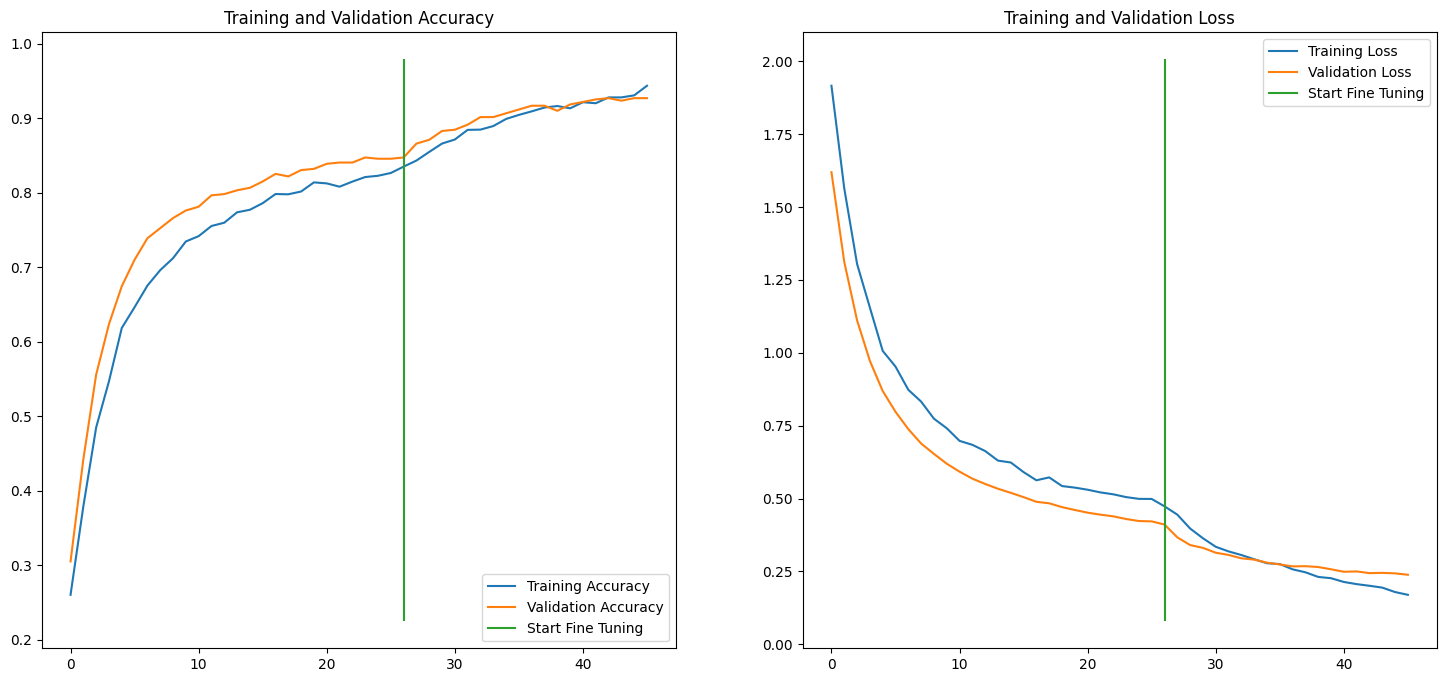

2024-11-21 10:26:42.941906: W tensorflow/core/kernels/data/cache_dataset_ops.cc:914] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


4/4 [==============================] - 0s 20ms/step - loss: 0.2650 - accuracy: 0.9028
Test accuracy : 0.9027777910232544
4/4 [==============================] - 1s 16ms/step
Classification Report:
              precision    recall  f1-score   support

       daisy       0.93      0.93      0.93        15
   dandelion       0.89      0.98      0.93        42
       roses       0.96      0.81      0.88        27
  sunflowers       0.93      0.90      0.92        30
      tulips       0.84      0.87      0.85        30

    accuracy                           0.90       144
   macro avg       0.91      0.90      0.90       144
weighted avg       0.91      0.90      0.90       144



2024-11-21 10:26:44.639648: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Confusion Matrix:
tf.Tensor(
[[14  1  0  0  0]
 [ 0 41  0  0  1]
 [ 0  1 22  0  4]
 [ 0  3  0 27  0]
 [ 1  0  1  2 26]], shape=(5, 5), dtype=int32)


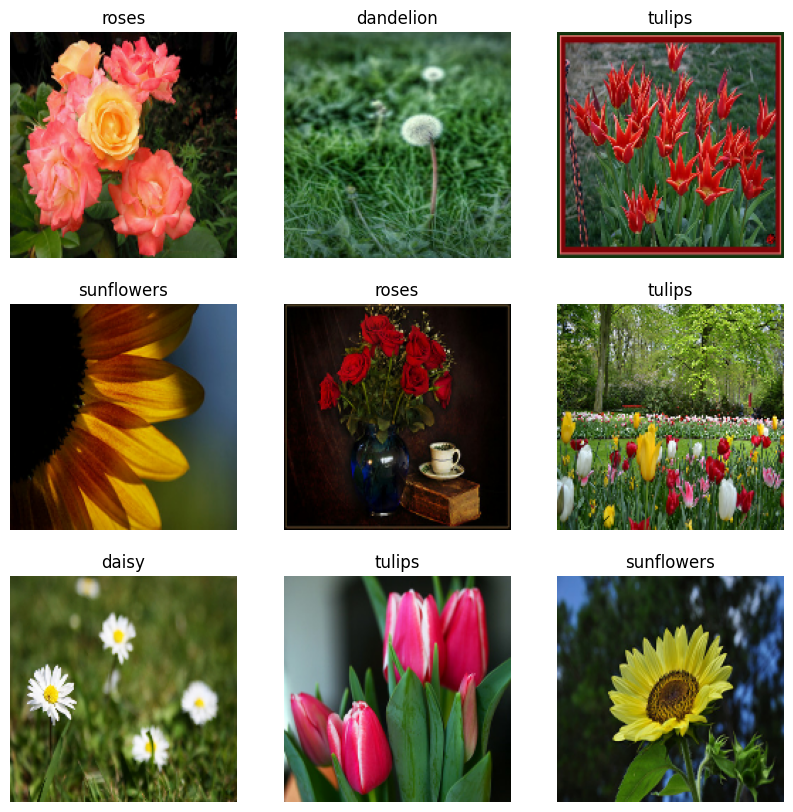

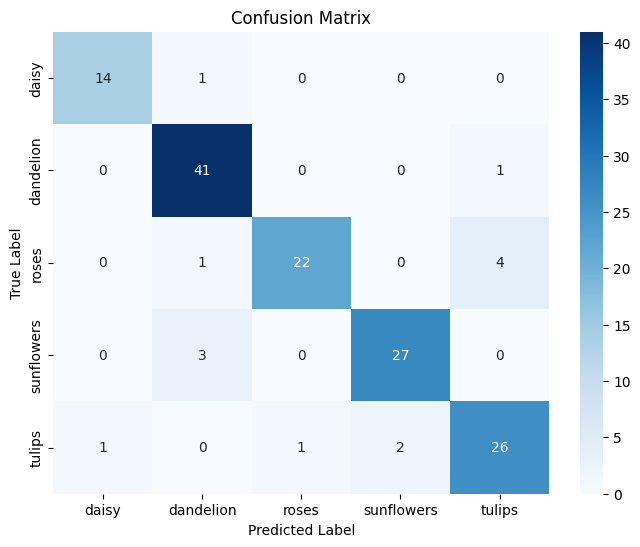

In [24]:
# Re-import the MobileNetV3Large again for fine-tuning
base_model_js = keras.applications.MobileNetV3Large(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights='imagenet',
)

model_js = retrain_model(base_model=base_model_js,
                      initial_epochs=50, fine_epochs=50,)

In [25]:
tfjs.converters.save_keras_model(model_js, './models/flower_net_k3_js')

/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
model_js.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 160, 160, 3)]     0         
                                                                 
 lambda (Lambda)             (None, 160, 160, 3)       0         
                                                                 
 MobilenetV3large (Function  (None, 5, 5, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 output (Dense)              (None, 5)                 4805  

In [32]:
model_js.layers[5]

In [33]:
# After training the model
# Extract the trained layers (exclude augmentation layers)
inference_inputs = keras.Input(shape=IMG_SHAPE)

# Reuse layers from training_model
x = process_input(inference_inputs)
x = model_js.layers[2](x)  # Base model (reuse from model_js)
x = model_js.layers[3](x)  # Global Average Pooling layer
x = model_js.layers[4](x)  # Dropout layer
inference_outputs = model_js.layers[5](x)  # Dense (final output layer)

# Build the inference model with trained weights
inference_model = keras.Model(inference_inputs, inference_outputs)

# Save the inference model
inference_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 MobilenetV3large (Function  (None, 5, 5, 960)         2996352   
 al)                                                             
                                                                 
 global_average_pooling2d (  (None, 960)               0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 960)               0         
                                                                 
 output (Dense)              (None, 5)                 4805      
                                                                 
Total params: 3001157 (11.45 MB)
Trainable params: 2867157 

In [34]:
tfjs.converters.save_keras_model(inference_model, './models/flower_net_k4_js')

/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [38]:
inference_model.save('./models/flower_net_k4.h5')

/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
% tensorflowjs_converter --input_format=keras \
                            --output_format=tfjs_graph_model \
                         ./models/flower_net_k4.h5 \
                         ./models/flower_net_k4_saved_js

UsageError: Line magic function `%` not found.


In [105]:
model_sq2 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMG_SHAPE, name='input_image'),
    base_model_js,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes),
])

model_sq2.summary()

/media/rayat69/Essentials/Programming/python/dl-1/.venv/lib/python3.10/site-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 5, 5, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_5      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 960)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 5)              │         4,805 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,001,157 (11.45 MB)

 Trainable params: 2,816,805 (10.75 MB)

 Non-trainable params: 184,352 (720.12 KB)

In [119]:
model_sq3 = tf.keras.Sequential([
    tf.keras.layers.InputLayer(shape=(100,100,3), name='input_image'),
    # base_model_js,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes),
])

model_sq3.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ global_average_pooling2d_12     │ (None, 3)              │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 5)              │            20 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20 (80.00 B)

 Trainable params: 20 (80.00 B)

 Non-trainable params: 0 (0.00 B)

In [121]:
tfjs.converters.save_keras_model(model_sq3, './models/model_sq3')

failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
# Clear all previously registered custom objects
keras.utils.get_custom_objects().clear()

# Upon registration, you can optionally specify a package or a name.
# If left blank, the package defaults to `Custom` and the name defaults to
# the class name.
@keras.utils.register_keras_serializable(package="Classify")
class Classify(keras.layers.Layer):
  def __init__(self, classes, **kwargs):
        super().__init__(**kwargs)
        self.classes = tf.constant(classes)

  def call(self, inputs):
      index = tf.argmax(inputs, axis=-1)
      label = tf.gather(self.classes, index)
      return label

  def get_config(self):
    base_config = super().get_config()
    config = {
        "classes": keras.saving.serialize_keras_object(self.classes),
    }
    return {**base_config, **config}

  @classmethod
  def from_config(cls, config):
      classes_config = config.pop("classes")
      classes = keras.saving.deserialize_keras_object(classes_config)
      return cls(classes, **config)